In [1]:
import argparse
import scipy
from scipy import ndimage
import cv2
import numpy as np
import sys
import json
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
from collections import OrderedDict
import os 
import scipy.ndimage as nd
from math import ceil
from PIL import Image

from networks.baseline import Res_Deeplab

### 0. Define color map

In [2]:
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """

    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette
palette = get_palette(256)

### 1. Select GPU environment 

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

### 2. Define Model

In [4]:
model = Res_Deeplab(num_classes=40)
saved_state_dict = torch.load('dataset/model.pth')
model.load_state_dict(saved_state_dict)
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, devices=[0], activation=none)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, devices=[0], activation=none)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): InPlaceABNSync(128, eps=1e-05, momentum=0.1, affine=True, devices=[0], activation=none)
  (relu3): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, devices=[0], activation=none)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stri

### 3. Read prepocess Image and depth

In [5]:
img = Image.open('image/1.jpg')
depth = Image.open('image/1_depth.png')

img = np.array(img).astype(np.float32)
img = (img - np.asarray([122.675,116.669,104.008]))[:,:,::-1]
img = np.array(img).astype(np.float32).transpose((2, 0, 1))[np.newaxis, ...]
img = torch.from_numpy(img).float().cuda()

## convert depth to xyz
depth = np.array(depth).astype(np.float32)
depth = depth[np.newaxis, ...]
_, h,w = depth.shape
z = depth
xx, yy = np.meshgrid(np.array(range(w))+1, np.array(range(h))+1)
fx_rgb = 5.18857e+02 
fy_rgb = 5.19469e+02
cx_rgb = w / 2.0
cy_rgb = h / 2.0
C = np.array([[fx_rgb, 0, cx_rgb], [0, fy_rgb, cy_rgb], [0, 0, 1]])
cc_rgb = C[0:2, 2]
fc_rgb = np.diag(C[0:2, 0:2])
x = (np.multiply((xx - cc_rgb[0]), z) / fc_rgb[0])
y = (np.multiply((yy - cc_rgb[1]), z) / fc_rgb[1])
depth = np.concatenate([x, y, z], axis=0)[np.newaxis, ...]
depth = torch.from_numpy(depth).float().cuda()

### 4. Forward and output results

In [6]:
pred, _ = model(img, depth, depth)
pred = F.upsample(input=pred, size=(480, 640), mode='bilinear', align_corners=True)
pred = np.asarray(np.argmax(pred.cpu().detach().numpy()[0, ...], axis=0), dtype=np.uint8)
pred_img = Image.fromarray(pred)
pred_img.putpalette(palette)
pred_img.save('image/result.png')

/home/linzhuo/anaconda3/envs/py35torch41/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


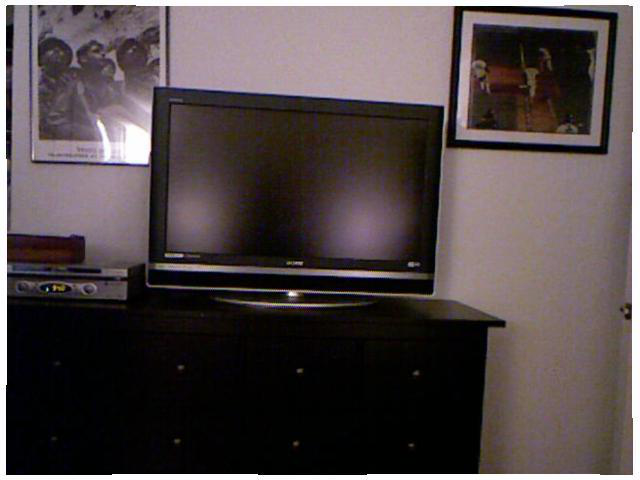

In [9]:
img = Image.open('image/1.jpg')
img

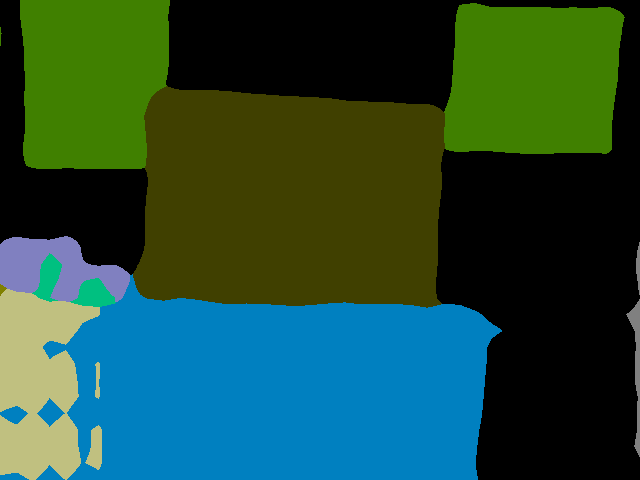

In [10]:
pred_img